# mlbotの初心者向けチュートリアル 売買方法模索

この記事ではmlbot(機械学習を使った仮想通貨自動売買ボット)を初心者向けに解説します。

前提

- 研究の足がかりとなるもの
- そのままでは儲からない

### 環境構築方法

https://github.com/richmanbtc/mlbot_tutorial に記載

### 上級者向けチュートリアル

以下のチュートリアルも合わせて読むと良いと思います。

- [ハイパーパラメータチューニング](https://github.com/richmanbtc/mlbot_tutorial/blob/master/work/hyper_parameter_tuning.ipynb)
- [Non-Stationarity Score](https://github.com/richmanbtc/mlbot_tutorial/blob/master/work/non_stationarity_score.ipynb)
- [p平均法](https://github.com/richmanbtc/mlbot_tutorial/blob/master/work/p_mean.ipynb)

### 教科書

[Kaggleで勝つデータ分析の技術](https://www.amazon.co.jp/dp/4297108437)を読むと、
実践的な機械学習の知識が身につきます。

この本には、Kaggle上位勢が実際に使っている、
性能が上がりやすい手法が書かれています。
コード例もあるので勉強しやすいです。

もし、このチュートリアルがわからない場合は、
この本を買うと良いと思います。


## 必要なライブラリのインポート

以下のコードでは必要なライブラリをインポートしています。

In [1]:
import math

import ccxt
from crypto_data_fetcher.gmo import GmoFetcher
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

## データを用意

以下のコードでは、例としてGMOコインのBTC/JPYレバレッジ取引の15分足データをohlcv形式で取得しています。
データ取得用のライブラリ https://github.com/richmanbtc/crypto_data_fetcher を利用しています。
ライブラリ内ではAPIでデータを取得しています。

https://note.com/btcml/n/nd78671a67792 を利用すると、高速にデータを読み込めます。

### ohlcv形式

ohlcv形式は、ローソク足と出来高を合わせたデータ形式です。
Open(始値)、High(高値)、Low(安値)、Close(終値)、Volume(出来高)の頭文字を並べるとohlcvになります。

カラムの意味は以下のようになっています。

- timestamp: 時刻(UTC)
- op: 始値
- hi: 高値 
- lo: 低値
- cl: 終値
- volume: 出来高

### 実験データ期間について

コード中のコメントにあるように、実験に使うデータ期間を限定します。
理由は、フィッティングを防ぐためです。

仮想通貨データはサンプル数が少ないので、
同じデータで何度も実験をすると、
正しくバリデーションしていたとしても
だんだんとデータにフィッティングしていきます。

実験に使わないデータを残しておくと、その部分についてはフィッティングを防げます。
全期間のデータで実験したときに、
実験に使った期間と使わなかった期間でバックテストの傾向が変わらなければ、
フィッティングの影響は少ないと判断できます。

また、本番用のモデルを学習するときは、
全期間のデータを使って学習したほうが良いと思います。
精度が上がりやすいからです。

### 改良ポイント

#### 取引所と取引ペア選び

いろいろな取引所やBTC/JPY以外のペアを試すと良いかもしれません。
取引ペアごとに値動きの傾向は変わります。
同じペアでも取引所ごとに値動きの傾向は変わります。

#### 時間軸(足の間隔)変更

時間軸によって値動きの傾向が変わります。
学習、バックテスト、検定などにも影響を与えます。
いろいろな時間軸を試すと良いかもしれません。

時間軸が短いメリット

- 値動きを予測しやすい
- サンプル数が多くなり、統計的に有意になりやすい
- サンプル数が多くなり、学習が成功しやすい

時間軸が長いメリット

- バックテストと実際の誤差が出づらい (APIや取引所の処理遅延などの影響を受けづらい)
- 運用資金をスケールさせやすい

In [3]:
# memory = joblib.Memory('/tmp/gmo_fetcher_cache', verbose=0)
# fetcher = GmoFetcher(memory=memory)

# # GMOコインのBTC/JPYレバレッジ取引 ( https://api.coin.z.com/data/trades/BTC_JPY/ )を取得
# # 初回ダウンロードは時間がかかる
# df = fetcher.fetch_ohlcv(
#     market='BTC_JPY', # 市場のシンボルを指定
#     interval_sec=15 * 60, # 足の間隔を秒単位で指定。この場合は15分足
# )

# 実験に使うデータ期間を限定する
df = pd.read_pickle('df_ohlcv.pkl')
df = df[df.index > pd.to_datetime('2024-02-08 00:00:00Z')]

display(df)
df.to_pickle('df_ohlcv.pkl')

,op,hi,lo,cl,volume
timestamp,,,,,
2024-02-08 00:15:00+00:00,6560201.0,6610980.0,6559399.0,6579916.0,31.23
2024-02-08 00:30:00+00:00,6581962.0,6602399.0,6574052.0,6592879.0,18.01
2024-02-08 00:45:00+00:00,6590804.0,6614928.0,6581962.0,6612774.0,15.54
2024-02-08 01:00:00+00:00,6612546.0,6613961.0,6593667.0,6595400.0,10.61
2024-02-08 01:15:00+00:00,6598088.0,6606546.0,6583472.0,6597493.0,11.43
...,...,...,...,...,...
2024-02-09 19:45:00+00:00,7094133.0,7103475.0,7074658.0,7087562.0,3.89
2024-02-09 20:00:00+00:00,7089778.0,7108818.0,7087292.0,7104400.0,4.72
2024-02-09 20:15:00+00:00,7107116.0,7112919.0,7087915.0,7094632.0,7.34


## maker手数料カラムを追加

以下のコードでは、maker手数料カラム(fee)を追加しています。
GMOコインは過去に何度か手数料を変更しているので、
バックテストを正確に行うために、
各時刻ごとの手数料が必要です。
このチュートリアルでは指値(maker)注文しか使わないので、追加するのはmaker手数料だけです。

GMOコインの過去のニュースから、
手数料の変更タイミングと変更後の手数料の値を人力で取得し、
そこから各時刻の手数料を設定しています。

手数料の変更は定期メンテナンスのときに行われたみたいです。
定期メンテナンスの時刻は日本時間の15:00〜16:00です。
UTCの場合は6:00〜7:00です。

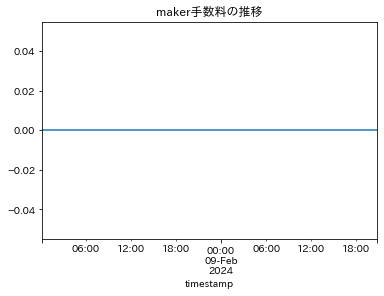

,op,hi,lo,cl,volume,fee
timestamp,,,,,,
2024-02-08 00:15:00+00:00,6560201.0,6610980.0,6559399.0,6579916.0,31.23,0.0
2024-02-08 00:30:00+00:00,6581962.0,6602399.0,6574052.0,6592879.0,18.01,0.0
2024-02-08 00:45:00+00:00,6590804.0,6614928.0,6581962.0,6612774.0,15.54,0.0
2024-02-08 01:00:00+00:00,6612546.0,6613961.0,6593667.0,6595400.0,10.61,0.0
2024-02-08 01:15:00+00:00,6598088.0,6606546.0,6583472.0,6597493.0,11.43,0.0
...,...,...,...,...,...,...
2024-02-09 19:45:00+00:00,7094133.0,7103475.0,7074658.0,7087562.0,3.89,0.0
2024-02-09 20:00:00+00:00,7089778.0,7108818.0,7087292.0,7104400.0,4.72,0.0
2024-02-09 20:15:00+00:00,7107116.0,7112919.0,7087915.0,7094632.0,7.34,0.0


In [4]:

maker_fee_history = [
    {
        # https://coin.z.com/jp/news/2020/08/6482/
        # 変更時刻が記載されていないが、定期メンテナンス後と仮定
        'changed_at': '2020/08/05 06:00:00Z',
        'maker_fee': -0.00035
    },
    {
        # https://coin.z.com/jp/news/2020/08/6541/
        'changed_at': '2020/09/09 06:00:00Z',
        'maker_fee': -0.00025
    },
    {
        # https://coin.z.com/jp/news/2020/10/6686/
        'changed_at': '2020/11/04 06:00:00Z',
        'maker_fee': 0.0
    },
]

df = pd.read_pickle('df_ohlcv.pkl')

# 初期の手数料
# https://web.archive.org/web/20180930223704/https://coin.z.com/jp/corp/guide/fees/
df['fee'] = 0.0

for config in maker_fee_history:
    df.loc[pd.to_datetime(config['changed_at']) <= df.index, 'fee'] = config['maker_fee']

df['fee'].plot()
plt.title('maker手数料の推移')
plt.show()
    
display(df)
# df.to_pickle('df_ohlcv_with_fee.pkl')

## 特徴量エンジニアリング

以下のコードではテクニカル指標計算ライブラリの[TA-Lib](https://mrjbq7.github.io/ta-lib/)を利用して特徴量を作成しています。
特徴量の意味は深く考えていません。
TA-Libで実装されている特徴量を片っ端から追加しただけです。
ただし、以下のように気をつけることはあります。

### 特徴量で気をつけること

#### 未来の情報が含まれないようにする

未来の情報は本番稼働時には使えません。
また、未来の情報が含まれると、予測精度が劇的に上がることが多いです。
予測精度が劇的に上がったときは、未来の情報が含まれていないか確認すると良いです。

#### どのくらい過去のデータに依存するか？

TRIXなど、指数平均を使うような特徴量は、無限の過去に依存します。
このことは過去データが全て存在するバックテストでは問題になりづらいですが、
本番稼働で問題になります。
本番稼働ではボットの計算が遅いと発注が遅れて取引機会を逃すことがあります。
ボットの計算を速くするためには、
過去データを全て取得してから予測値を計算するのでは無く、
過去一定の期間、例えば直近一ヶ月のみを取得して計算することをよくやります。
このときにTRIXなどは計算に誤差が生まれます。
誤差は計算に使う期間を長くすれば減ります。
https://www.ta-lib.org/d_api/ta_setunstableperiod.html も参考になります。

以下のような対応をします。
無限の過去に依存する特徴量は、誤差が十分小さくなるようなデータ期間で計算する。
有限の過去に依存する特徴量は、依存する最大長以上のデータ期間で計算する。

### 改良ポイント

#### 特徴量の改善

いろいろな特徴量を試すと良いと思います。
TA-Libのようなテクニカル指標以外にも、以下のような特徴量が考えられます。

- 板情報 (Order Book)
- 価格帯別出来高 (Volume Profile Visible Range, VPVR)
- オープンインタレスト (Open Interest, OI)
- 清算 (Liquidation)
- オンチェーンデータ
- SNSデータ (単語を含むツイート数や、自然言語処理など)

上級者向けチュートリアルに記載のrichman non-stationarity scoreが下がるような特徴量を探すのもおすすめです。

以下のようなTA-Lib以外のライブラリを試すのも良いと思います。

- https://github.com/bukosabino/ta

In [90]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    hilo = (df['hi'] + df['lo']) / 2
    # 価格(hilo または close)を引いた後、価格(close)で割ることで標準化
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] = (df['BBANDS_upperband'] - hilo) / close
    df['BBANDS_middleband'] = (df['BBANDS_middleband'] - hilo) / close
    df['BBANDS_lowerband'] = (df['BBANDS_lowerband'] - hilo) / close
    df['DEMA'] = (talib.DEMA(close, timeperiod=30) - hilo) / close
    df['EMA'] = (talib.EMA(close, timeperiod=30) - hilo) / close
    df['HT_TRENDLINE'] = (talib.HT_TRENDLINE(close) - hilo) / close
    df['KAMA'] = (talib.KAMA(close, timeperiod=30) - hilo) / close
    df['MA'] = (talib.MA(close, timeperiod=30, matype=0) - hilo) / close
    df['MIDPOINT'] = (talib.MIDPOINT(close, timeperiod=14) - hilo) / close
    df['SMA'] = (talib.SMA(close, timeperiod=30) - hilo) / close
    df['T3'] = (talib.T3(close, timeperiod=5, vfactor=0) - hilo) / close
    df['TEMA'] = (talib.TEMA(close, timeperiod=30) - hilo) / close
    df['TRIMA'] = (talib.TRIMA(close, timeperiod=30) - hilo) / close
    df['WMA'] = (talib.WMA(close, timeperiod=30) - hilo) / close
    df['LINEARREG'] = (talib.LINEARREG(close, timeperiod=14) - close) / close
    df['LINEARREG_INTERCEPT'] = (talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close) / close


    # 価格(close)で割ることで標準化
    df['AD'] = talib.AD(high, low, close, volume) / close
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10) / close
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0) / close
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_PHASOR_inphase'] /= close
    df['HT_PHASOR_quadrature'] /= close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14) / close
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD_macd'] /= close
    df['MACD_macdsignal'] /= close
    df['MACD_macdhist'] /= close
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14) / close
    df['MOM'] = talib.MOM(close, timeperiod=10) / close
    df['OBV'] = talib.OBV(close, volume) / close
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14) / close
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1) / close
    df['TRANGE'] = talib.TRANGE(high, low, close) / close


    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)

    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    return df

#df = pd.read_pickle('df_ohlcv_with_fee.pkl')
df = pd.read_csv('binance_btc_usdt_15m.csv')

# use binance data
df.columns = ['datetime', 'op', 'hi', 'lo', 'cl', 'volume']


df['fee'] = 0
# インデックスを日付型に変換
#df.index = pd.to_datetime(df.index)
#df.set_index('datetime', inplace=True)


# DateTime列を日付型に変換
df['datetime'] = pd.to_datetime(df['datetime'])

# 2024年のデータだけをフィルタリング
df = df[(df['datetime'].dt.year == 2024) & (df['datetime'].dt.month == 2)]



df = df.dropna()
df = calc_features(df)
display(df)
df.to_pickle('my_df_features.pkl')

,datetime,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,...,ATR,NATR,HT_DCPERIOD,HT_DCPHASE,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG_ANGLE
399798,2024-02-01 00:00:00,42882.08,42946.86,42802.00,42905.04,461.63744,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
399799,2024-02-01 00:15:00,42905.04,43026.15,42691.10,43016.80,644.56655,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
399800,2024-02-01 00:30:00,43016.80,43465.02,43016.79,43380.00,1439.97874,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
399801,2024-02-01 00:45:00,43379.99,43461.10,43285.75,43361.10,731.23076,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
399802,2024-02-01 01:00:00,43361.11,43611.80,43294.46,43508.89,954.96771,0,0.005623,-0.005028,-0.015679,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399994,2024-02-03 01:00:00,43242.10,43488.00,43234.49,43390.00,1310.14933,0,0.001914,-0.003938,-0.009790,...,147.627589,0.340234,20.397088,46.942643,0.730671,0.999425,0,-0.524030,0.885172,87.343053
399995,2024-02-03 01:15:00,43389.99,43390.00,43100.90,43200.01,588.57912,0,0.004597,-0.000729,-0.006054,...,157.732761,0.365122,19.863306,68.027095,0.927361,0.920320,0,0.417363,0.873693,88.227137
399996,2024-02-03 01:30:00,43200.01,43268.61,43132.24,43134.70,482.04467,0,0.004741,0.000803,-0.003134,...,156.206850,0.362137,19.471057,94.779998,0.996522,0.645724,0,0.438092,0.880490,88.525731
399997,2024-02-03 01:45:00,43134.69,43289.43,43100.00,43216.36,425.42442,0,0.004880,0.000970,-0.002940,...,158.579932,0.366944,19.155240,113.933473,0.914017,0.359452,0,0.472951,0.881433,88.806773


## 学習に使う特徴量の定義

以下のコードでは学習に使う特徴量カラムを指定しています。
特徴量は私が適当に選んだものです。
コメントアウトなどでいろいろな組み合わせを試すと良いと思います。
特徴量選択もおすすめです。
Kaggleで勝つデータ分析の技術などで勉強すると良いと思います。

In [91]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

print(features)

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA']


In [4]:
import numpy as np
import pandas as pd

# データフレームを想定して、価格データのサンプルを作成します。
# 'price'は取引価格を、'volume'はその時点での取引量を表します。
# data = {
#     'price': [100, 101, 102, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87],
#     'volume': [10, 11, 12, 13, 14, 15, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]
# }
# df = pd.DataFrame(data)

# 短期EMAと中期EMAの計算期間を定義します。
short_ema_period = 5
mid_ema_period = 8

# 短期EMAと中期EMAを計算します。
df['short_ema'] = df['cl'].ewm(span=short_ema_period, adjust=False).mean()
df['mid_ema'] = df['cl'].ewm(span=mid_ema_period, adjust=False).mean()

# VWAPを計算します。
df['vwap_numerator'] = df['cl'] * df['volume']
df['vwap_denominator'] = df['volume']
df['VWAP'] = df['vwap_numerator'].cumsum() / df['vwap_denominator'].cumsum()

# 現在価格がVWAPよりも下にあり、短期EMAが中期EMAを上向きに交差した場所を特定します。
# 交差ポイントを検出するために、EMAの差分を計算し、前の期間と比較します。
df['ema_diff'] = df['short_ema'] - df['mid_ema']
df['ema_diff_prev'] = df['ema_diff'].shift(1)
df['buy_signal'] = (df['ema_diff'] > 0) & (df['ema_diff_prev'] < 0) & (df['cl'] < df['VWAP'])

print(df[['cl', 'short_ema', 'mid_ema', 'VWAP', 'buy_signal']])
df.to_pickle('my_df_features.pkl')
df[df['buy_signal'] == True]
# 結果０

              cl     short_ema       mid_ema          VWAP  buy_signal
399798  42905.04  42905.040000  42905.040000  42905.040000       False
399799  43016.80  42942.293333  42929.875556  42970.160681       False
399800  43380.00  43088.195556  43029.903210  43201.942909       False
399801  43361.10  43179.163704  43103.502497  43237.452789       False
399802  43508.89  43289.072469  43193.588608  43298.698164       False
...          ...           ...           ...           ...         ...
399994  43390.00  43196.995433  43122.571173  42815.413789       False
399995  43200.01  43198.000289  43139.779801  42818.273043       False
399996  43134.70  43176.900192  43138.650957  42820.188036       False
399997  43216.36  43190.053462  43155.919633  42822.292781       False
399998  43280.12  43220.075641  43183.519715  42823.887530       False

[201 rows x 5 columns]


,datetime,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,...,CORREL,LINEARREG_ANGLE,short_ema,mid_ema,vwap_numerator,vwap_denominator,VWAP,ema_diff,ema_diff_prev,buy_signal
399854,2024-02-01 14:00:00,42073.43,42187.16,42028.41,42151.28,413.13553,0,0.001343,-0.000764,-0.002872,...,0.969957,-28.344667,42094.822998,42092.836235,1.741419e+07,413.13553,42799.230320,1.986763,-9.543520,True
399857,2024-02-01 14:45:00,42099.60,42161.10,42099.60,42156.50,163.50543,0,0.001393,-0.000557,-0.002506,...,0.966610,-12.532274,42110.341629,42102.882646,6.892817e+06,163.50543,42784.436411,7.458983,-0.300958,True
399868,2024-02-01 17:30:00,42154.99,42236.00,42138.53,42235.99,159.65130,0,0.002765,0.000244,-0.002277,...,0.765910,82.019312,42195.218453,42190.254900,6.743031e+06,159.65130,42736.107480,4.963553,-2.355049,True
399874,2024-02-01 19:00:00,42148.31,42216.29,42112.95,42216.28,196.41352,0,0.001909,0.000678,-0.000553,...,0.896420,-37.824036,42195.629741,42195.548460,8.291848e+06,196.41352,42717.990751,0.081281,-4.320551,True
399889,2024-02-01 22:45:00,42185.15,42257.83,42150.00,42219.61,257.24811,0,0.001967,-0.001337,-0.004640,...,0.722718,-80.401325,42176.122365,42172.857412,1.086091e+07,257.24811,42647.893730,3.264953,-5.120983,True


In [37]:

# """各行ごとに異なるウィンドウ期間でサポートとレジスタンスレベルを計算するPythonスクリプトの改善版を以下に示します。このスクリプトでは、各行に対して動的にウィンドウ期間を設定し、その期間内での最低価格（サポート）と最高価格（レジスタンス）を計算します。"""
# import numpy as np
# import pandas as pd

# # サンプルデータの生成
# # np.random.seed(0)
# # dates = pd.date_range('20230101', periods=100)
# # data = np.random.rand(100, 5) * 100
# # columns = ['Open', 'High', 'Low', 'Close', 'Volume']
# # df = pd.DataFrame(data, index=dates, columns=columns)

def calc_support_resistance(row, df):
    """
    各行に対して、指定されたウィンドウ期間でサポートとレジスタンスレベルを計算します。
    この例では、各行のインデックス位置を利用してウィンドウ期間を動的に設定します。
    """
    # 現在の行のインデックス位置を取得
    idx = df.index.get_loc(row.name)
    # ウィンドウ期間を動的に設定（例えば、5日間とする）
    window = max(5, idx + 1)  # 最初の数行ではウィンドウ期間を保証
    # ウィンドウ期間内のデータを抽出
    window_df = df.iloc[max(0, idx - window + 1):idx + 1]
    # サポートとレジスタンスレベルを計算
    support = window_df['lo'].min()
    resistance = window_df['hi'].max()
    return pd.Series([support, resistance], index=['Support', 'Resistance'])

# インデックスをリセットする場合
df = df.reset_index(drop=True)
# applyを使用して各行にサポートとレジスタンスレベルの計算を適用
df[['Support', 'Resistance']] = df.apply(lambda row: calc_support_resistance(row, df), axis=1)

# 結果の表示
print(df[['Support', 'Resistance']].head())



import numpy as np
import pandas as pd

# サンプルデータの生成（コメントアウトを解除して使用）
# np.random.seed(0)
# dates = pd.date_range('20230101', periods=100)
# data = np.random.rand(100, 5) * 100
# columns = ['Open', 'High', 'Low', 'Close', 'Volume']
# df = pd.DataFrame(data, index=dates, columns=columns)

# # 効率的なサポートとレジスタンスレベルの計算
# def efficient_support_resistance(df, min_window=5):
#     support = pd.Series(index=df.index)
#     resistance = pd.Series(index=df.index)
    
#     for i in range(len(df)):
#         window = max(min_window, i + 1)
#         window_df = df.iloc[max(0, i - window + 1):i + 1]
#         support.iloc[i] = window_df['lo'].min()
#         resistance.iloc[i] = window_df['hi'].max()
        
#     return support, resistance

# # サポートとレジスタンスレベルの計算
# df['Support'], df['Resistance'] = efficient_support_resistance(df)

# # 結果の表示
# print(df[['Support', 'Resistance']].tail())
# df.to_pickle('my_df_features.pkl')
df

    Support  Resistance
0  42612.76    42700.08
1  42612.76    42733.81
2  42612.76    42740.76
3  42612.76    42748.00
4  42594.94    42748.00


,datetime,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,...,buy_executed,sell_executed,y_buy,y_sell,buy_cost,sell_cost,y_pred_buy,y_pred_sell,cum_ret,poss
0,2024-01-01 22:00:00,42648.37,42700.08,42612.76,42700.08,139.84328,0,0.002714,0.000622,-0.001470,...,0.0,0.0,0.00,0.00,0.000000,0.000000,-32.442902,40.914060,0.000000,0.0
1,2024-01-01 22:15:00,42700.07,42733.81,42700.00,42717.27,134.09815,0,0.001295,-0.000369,-0.002033,...,0.0,0.0,0.00,0.00,0.000000,0.000000,-6.080934,43.425721,0.000000,0.0
2,2024-01-01 22:30:00,42717.28,42740.76,42670.00,42740.76,114.59877,0,0.001911,0.000165,-0.001580,...,0.0,0.0,0.00,0.00,0.000000,0.000000,-61.247046,18.216492,0.000000,0.0
3,2024-01-01 22:45:00,42740.75,42748.00,42704.80,42715.54,108.66220,0,0.000931,-0.000515,-0.001961,...,1.0,0.0,26.45,0.00,-0.001077,0.000000,-38.605946,9.241578,0.000000,0.0
4,2024-01-01 23:00:00,42715.54,42715.55,42594.94,42646.99,191.85635,0,0.002618,0.001146,-0.000326,...,1.0,0.0,97.00,0.00,-0.001126,0.000000,-33.011158,28.097618,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,2024-01-11 22:00:00,47449.64,47449.64,47158.10,47171.76,960.11643,0,0.004283,-0.001895,-0.008074,...,0.0,1.0,0.00,295.76,0.000000,-0.002777,23.057216,-18.913842,-0.074318,0.0
961,2024-01-11 22:15:00,47171.77,47350.00,47088.00,47140.00,791.41447,0,0.005430,0.000428,-0.004574,...,1.0,0.0,173.12,0.00,-0.002821,0.000000,-26.235493,-171.476783,-0.074318,0.0
962,2024-01-11 22:30:00,47139.99,47201.32,46762.86,47038.12,1875.94549,0,0.010987,0.005002,-0.000982,...,0.0,1.0,0.00,-455.47,0.000000,-0.003019,-44.318927,-258.543057,-0.074318,0.0
963,2024-01-11 22:45:00,47038.12,47325.99,47037.21,47325.20,777.22658,0,0.007054,0.000916,-0.005222,...,0.0,1.0,0.00,-165.39,0.000000,-0.003064,-62.552615,-15.533781,-0.074318,0.0


## 目的変数の計算

以下のコードでは目的変数(y)を計算しています。
目的変数は、機械学習が予測する対象です。
yと表記されることが多いです。
買いはy_buy、売りはy_sellとしています。

何をyとするかは、いろいろなやり方があります。
このチュートリアルでは、
実際の取引ルールに従ってトレードした場合に得られるリターンをyとしています。
指値が約定するかどうかと手数料を考慮してリターンを計算しています。

### Force Entry Price

Force Entry Priceは買うと決めてから約定するまで指値で追いかけた場合に、実際に約定する価格です。
私が独自に定義した用語です。
fepと略す場合もあります。
いくらで指値を出すかは外部から与える必要があります。
entryと名前がついていますが、exitも同じ計算なので区別はないです。
以下のコードではcalc_force_entry_priceでForce Entry Priceを計算しています。
コード中のforce_entry_timeは約定するまでにかかった時間です。
fetと略す場合もあります。

具体的には以下のように計算します。
詳細はコードを読んでください。

1. 毎時刻、与えられた指値価格で、指値を出す
2. 指値が約定したら、指値をForce Entry Priceとする
3. 指値が約定しなかったら、次の時刻へ進み、1へ戻る

### 実際の取引ルールに従ってトレードした場合に得られるリターン

具体的には以下のようにyを計算します。買い指値の場合で説明します。売り指値でもほぼ同じです。
詳細はコードを読んでください。

1. 毎時刻、あるルールで計算された指値距離(limit_price_dist)に基づいて、買い指値を出す
2. 買い指値が約定しなかった場合のyはゼロとする
3. 買い指値が約定した場合、一定時間(horizon)だけ待ってから、Force Entry Priceの執行方法でエグジットする
4. エグジット価格 / エントリー価格 - 1 - 2 * feeをyとする

### 改良のポイント

#### 執行の改善

チュートリアルでは、
毎時刻、指値を出すだけの執行を使っていますが、
損切りを入れたり、成行注文を使うなど、
他の執行方法も試すと良いかもしれません。

#### 指値価格の計算方法

チュートリアルでは、
ATRを使って指値価格を計算していますが、
他の計算方法も試すと良いかもしれません。

### 参考リンク

https://note.com/btcml/n/n9f730e59848c


In [86]:
df

,Open,High,Low,Close,Volume
2023-01-01,54.881350,71.518937,60.276338,54.488318,42.365480
2023-01-02,64.589411,43.758721,89.177300,96.366276,38.344152
2023-01-03,79.172504,52.889492,56.804456,92.559664,7.103606
2023-01-04,8.712930,2.021840,83.261985,77.815675,87.001215
2023-01-05,97.861834,79.915856,46.147936,78.052918,11.827443
...,...,...,...,...,...
2023-04-06,75.076486,69.957506,96.796557,99.440079,45.182168
2023-04-07,7.086978,29.279403,15.235471,41.748637,13.128933
2023-04-08,60.411780,38.280806,89.538588,96.779467,54.688490
2023-04-09,27.482357,59.223042,89.676116,40.673335,55.207828


In [92]:
import pandas as pd
import numpy as np

# サンプルOHLCVデータを読み込むためのコード（実際にはファイルから読み込むことを想定）
# ここでは、サンプルデータを生成して使用します
# np.random.seed(0)
# dates = pd.date_range(start='2023-01-01', periods=30, freq='D')  # 30日分のデータ
# data = np.random.rand(30, 5) * 100
# columns = ['Open', 'High', 'Low', 'Close', 'Volume']
# df = pd.DataFrame(data, index=dates, columns=columns)

# 各行に対して、直近10日間の最高値と最低値を基にフィボナッチリトレースメントレベルを計算する関数
def calc_fib_levels(row, df):
    # 現在の行のインデックス位置を取得
    idx = df.index.get_loc(row.name)
    # 直近10日間のデータを取得（最初の10日間は利用可能な日数に応じて調整）
    window_df = df.iloc[max(0, idx - 9):idx + 1]
    high = window_df['hi'].max()
    low = window_df['lo'].min()
    diff = high - low
    
    # フィボナッチリトレースメントレベルの計算
    fib_levels = [0.236, 0.382, 0.5, 0.618, 0.786]
    return {f"Fib_{level*100:.0f}%": high - (diff * level) for level in fib_levels}

# フィボナッチリトレースメントレベルの計算と結果の追加
for index, row in df.iterrows():
    fib_levels = calc_fib_levels(row, df)
    for level, price in fib_levels.items():
        df.at[index, level] = price

# 結果の表示（最初の5行を表示）
print(df.head())



                  datetime        op        hi        lo        cl  \
399798 2024-02-01 00:00:00  42882.08  42946.86  42802.00  42905.04   
399799 2024-02-01 00:15:00  42905.04  43026.15  42691.10  43016.80   
399800 2024-02-01 00:30:00  43016.80  43465.02  43016.79  43380.00   
399801 2024-02-01 00:45:00  43379.99  43461.10  43285.75  43361.10   
399802 2024-02-01 01:00:00  43361.11  43611.80  43294.46  43508.89   

            volume  fee  BBANDS_upperband  BBANDS_middleband  \
399798   461.63744    0               NaN                NaN   
399799   644.56655    0               NaN                NaN   
399800  1439.97874    0               NaN                NaN   
399801   731.23076    0               NaN                NaN   
399802   954.96771    0          0.005623          -0.005028   

        BBANDS_lowerband  ...  HT_SINE_leadsine  HT_TRENDMODE  BETA  CORREL  \
399798               NaN  ...               NaN             0   NaN     NaN   
399799               NaN  ...       

399798         NaN
399799         NaN
399800         NaN
399801         NaN
399802    42691.10
            ...   
399994    42750.00
399995    42942.95
399996    42989.09
399997    43100.00
399998    43100.00
Name: Support, Length: 201, dtype: float64

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


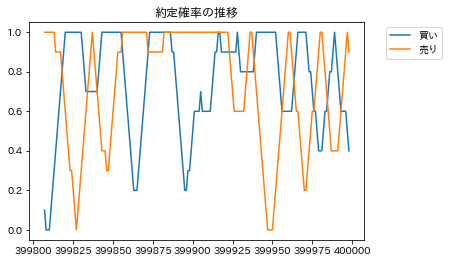

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


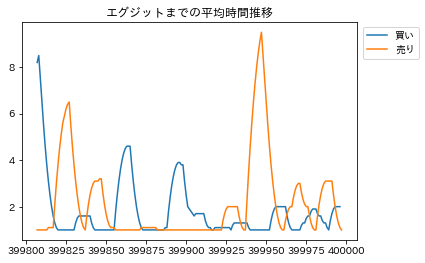

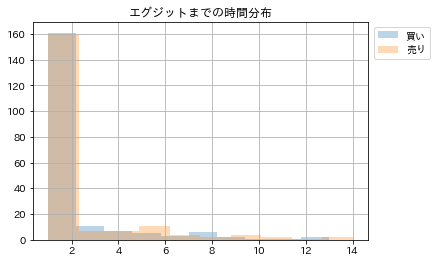

毎時刻、この執行方法でトレードした場合の累積リターン


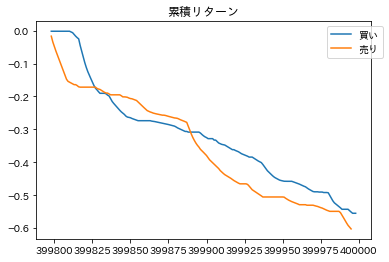

,datetime,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,...,buy_fep,buy_fet,sell_fep,sell_fet,buy_executed,sell_executed,y_buy,y_sell,buy_cost,sell_cost
399798,2024-02-01 00:00:00,42882.08,42946.86,42802.00,42905.04,461.63744,0,NaN,NaN,NaN,...,42891.52348,1.0,42857.33652,1.0,1.0,1.0,-0.001689,-0.016698,-0.000315,0.001112
399799,2024-02-01 00:15:00,42905.04,43026.15,42691.10,43016.80,644.56655,0,NaN,NaN,NaN,...,43572.96170,13.0,42819.08910,1.0,0.0,1.0,0.000000,-0.017606,0.000000,0.004596
399800,2024-02-01 00:30:00,43016.80,43465.02,43016.79,43380.00,1439.97874,0,NaN,NaN,NaN,...,43572.96170,12.0,42986.73744,1.0,0.0,1.0,0.000000,-0.013638,0.000000,0.009066
399801,2024-02-01 00:45:00,43379.99,43461.10,43285.75,43361.10,731.23076,0,NaN,NaN,NaN,...,43572.96170,11.0,42986.73744,1.0,0.0,1.0,0.000000,-0.013638,0.000000,0.008634
399802,2024-02-01 01:00:00,43361.11,43611.80,43294.46,43508.89,954.96771,0,0.005623,-0.005028,-0.015679,...,43572.96170,10.0,43042.80740,1.0,0.0,1.0,0.000000,-0.012317,0.000000,0.010712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399994,2024-02-03 01:00:00,43242.10,43488.00,43234.49,43390.00,1310.14933,0,0.001914,-0.003938,-0.009790,...,43128.45778,1.0,42906.33222,1.0,1.0,1.0,-0.004245,-0.005740,-0.006028,0.011147
399995,2024-02-03 01:15:00,43389.99,43390.00,43100.90,43200.01,588.57912,0,0.004597,-0.000729,-0.006054,...,43152.60400,1.0,42945.39600,1.0,1.0,1.0,-0.004182,-0.005211,-0.001097,0.005894
399996,2024-02-03 01:30:00,43200.01,43268.61,43132.24,43134.70,482.04467,0,0.004741,0.000803,-0.003134,...,43169.15224,1.0,42972.16776,1.0,1.0,1.0,-0.003746,NaN,0.000799,0.003768
399997,2024-02-03 01:45:00,43134.69,43289.43,43100.00,43216.36,425.42442,0,0.004880,0.000970,-0.002940,...,NaN,NaN,43007.45556,1.0,0.0,1.0,0.000000,NaN,0.000000,0.004834


In [96]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

#df = pd.read_pickle('my_df_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# # ATRで指値距離を計算します
#limit_price_dist = df['ATR'] * 0.9
#limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# # 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
# # buy_signalをみる、　Trueだったら値をセット
#df['buy_price'] = df['cl'] - limit_price_dist
#df['sell_price'] = df['cl'] + limit_price_dist


# buy_priceとsell_priceの設定
df['Support'] = df['lo'].rolling(window=5).min()
df['Resistance'] = df['hi'].rolling(window=10).max()
display(df['Support'])

df['buy_price'] = df['Support'] + (df['ATR'] * 0.02) # mit_price #(df['ATR'] * 0.8)  # サポートレベルを参照して調整可能
df['sell_price'] = df['Resistance'] - (df['ATR'] * 0.02) # limit_price_dist # (df['ATR'] * 0.8)  # レジスタンスレベルを参照して調整可能

# フィボナッチトレースメンとの値で売買
df['buy_price'] = df['Fib_38%']
df['sell_price'] = df['Fib_62%']

#df['buy_price'] = df['cl']
#df['sell_price'] = df['cl']


# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - ( (1 / df['sell_fep'].shift(-horizon)) * 0.01) - ( (1 / df['buy_price'] * 0.01)),
    #(df['sell_fep'].shift(-horizon) - df['buy_price']) - ( (1 / df['sell_fep'].shift(-horizon)) * 0.01) - ( (1 / df['buy_price'] * 0.01)),

    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - ( (1 / df['buy_fep'].shift(-horizon)) * 0.01) - ( (1 / df['sell_price'] * 0.01)),
    #(df['sell_price'] - df['buy_fep'].shift(-horizon)) - ( (1 / df['buy_fep'].shift(-horizon)) * 0.01) - ( (1 / df['sell_price'] * 0.01)),

    0
)

#バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(10).mean().plot(label='買い')
df['sell_executed'].rolling(10).mean().plot(label='売り')
plt.title('約定確率の推移')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(10).mean().plot(label='買い')
df['sell_fet'].rolling(10).mean().plot(label='売り')
plt.title('エグジットまでの平均時間推移')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='買い')
df['sell_fet'].hist(alpha=0.3, label='売り')
plt.title('エグジットまでの時間分布')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('my_df_y.pkl')
df


## モデルの学習とOOS予測値計算

本番稼働時に使うモデルの学習と、OOS(Out-of-sample)予測値の計算を行います。

基本的なアイデアはy_buy, y_sellを予測し、
予測値がプラスのときのみトレードすれば勝てるだろう、
というものです。
y_buy, y_sellそれぞれの予測モデルが必要です。

### 本番用モデルの学習

本番用モデルはデータ全体で学習させます。
y_buy、y_sellそれぞれの予測モデルを作り、保存します。
保存したモデルはこのチュートリアルでは使いません。
本番稼働するときに使います。

### OOS(Out-of-sample)予測値

Cross Validationを使って、y_buy, y_sellのOOS予測値を計算します。
OOS予測値はバックテストのために必要です。

Cross Validationはモデルの成績を測る方法の一つです。
大まかに言うと、
様々な方法でデータを学習データとテストデータに分割し、
学習データで学習させたモデルを、
テストデータで評価するという方法です。
詳細は[sklearnのドキュメント](https://scikit-learn.org/stable/modules/cross_validation.html)や、Kaggleで勝つデータ分析の技術を見てください。

OOS予測値は、モデルの学習に使っていないデータ期間でのモデル予測値のことです。
OOSはOut-of-sampleの略で、サンプル(学習に使ったデータサンプル)の外という意味があります。
OOSで計算する理由は、条件をなるべく本番と同じにするためです。
本番稼働時は、学習に使っていないデータ(未来のデータ)に対処しないといけません。

Cross Validationを使い、
OOS予測値を計算する関数がmy_cross_val_predictです。
my_cross_val_predictは、
[sklearn.model_selection.cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)とほぼ同じ処理ですが、
cross_val_predictは入力と出力のサイズが同じでないと使えないので、
入力と出力のサイズが異なっていても使えるように、
自前で書いています。
KFoldなら入力と出力のサイズが同じなのでsklearn.model_selection.cross_val_predictを使えますが、
TimeSeriesSplitでは使えません。

OOS予測値計算の流れは以下のようになります。

1. 様々な方法(cv_indicies)でデータを学習データ(train_idx)とテストデータ(val_idx)に分割
2. 学習データでモデルを学習(fit)
3. テストデータでモデル予測値を計算(predict)
4. 1に戻り、cv_indiciesの長さ分、繰り返す

以下のコードでは、y_buy, y_sellのOOS予測値を、それぞれy_pred_buy、y_pred_sellと表記しています。

### 改良ポイント

#### パージ

このチュートリアルで使う目的変数(y)は、
将来のリターンから計算するので、
計算に未来のデータが使われています。
特徴量の計算には過去のデータが使われています。
つまり、ある時刻のデータには前後のデータの情報が含まれています。

なので、
KFoldやTimeSeriesSplitで分割すると、
テストデータに学習データの情報が混入する可能性があります。

すると、バリデーションとして不適切になります。
実際の問題設定と乖離するからです。
実際は、将来のデータを学習時に利用することはできません。

これを防ぐために、パージという手法があります。
学習データからテストデータに時間的に近いデータを取り除く手法です。
このチュートリアルでは説明をシンプルにするために、パージを使っていません。

この辺のことは、
[ファイナンス機械学習―金融市場分析を変える機械学習アルゴリズムの理論と実践](https://www.amazon.co.jp/dp/4322134637)
に詳しく書かれています。


毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


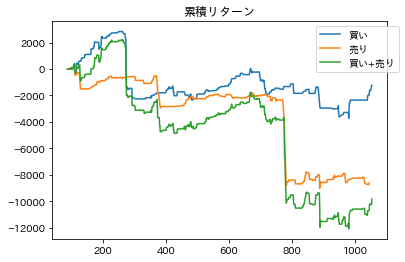

In [34]:
df = pd.read_pickle('my_df_y.pkl')
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)

# アンサンブル (コメントアウトを外して性能を比較してみてください)
# model = BaggingRegressor(model, random_state=1, n_jobs=1)

# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
model.fit(df[features], df['y_buy'])
joblib.dump(model, 'model_y_buy.xz', compress=True) 
model.fit(df[features], df['y_sell'])
joblib.dump(model, 'model_y_sell.xz', compress=True)

# 通常のCV
cv_indicies = list(KFold().split(df))
# ウォークフォワード法
# cv_indicies = list(TimeSeriesSplit().split(df))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='買い')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='売り')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('my_df_fit.pkl')

## バックテストと検定

バックテストと検定(統計的検定)を行います。

### バックテスト

バックテストとは、
過去データに対して、トレードをシミュレーションして、
どのくらいの成績が出るかを見ることです。

シンプルに考えると、
y_pred_buyがプラスのときだけy_buyを再現するようなトレードを行い、
y_pred_sellがプラスのときだけy_sellを再現するようなトレードを行えば、
前項の累積リターン(買い+売り)を再現できます。

しかし、これをそのまま再現しようとすると、
偶然にも、
買い指値のみ約定して、売り指値が約定しないことが続いた場合、
ポジションがロング側に増えていき、
レバレッジが上がってしまいます。
レバレッジが上がると、
取引所のレバレッジ制限、ポジションサイズ制限に引っかかったり、
急変時にロスカットされる可能性が高まるので、
良くないです。

そこで、ポジションサイズが大きくなりすぎないように、
以下のようなトレードルールでバックテストします。
具体的な計算式はソースコードを見てください。

1. 現在ポジションがプラスの場合、エグジット用の売り指値を出す
2. 現在ポジションがマイナスの場合、エグジット用の買い指値を出す
3. 最大ポジションまで余裕があり、y_pred_buyがプラスのとき、エントリー用の買い指値を出す
4. 最大ポジションまで余裕があり、y_pred_sellがプラスのとき、エントリー用の売り指値を出す

私の経験上、
このルールでトレードすると、
前項の累積リターン(買い+売り)とは少し差が出ますが、
だいたい似たような成績になります。

### 統計的検定とエラー率

統計的検定を使うと、
バックテストで得られた結果が偶然なのかそうでないのかを、
見積もれます。

検定ではエラー率が重要です。
ここで言うエラー率は、
False Positive(本当は偶然なのに、偶然ではないと判定されてしまうこと)の確率のことです。

エラー率は低いほど良いです。
エラー率は100000分の1以下が良いと思います。
その根拠は次の通りです。

実験は何度も行います。
仮に、実験を1000回行ったとすると、そのうちの一回くらいはFalse Positiveが出てしまうかもしれません。
そのまま運用したら勝てません。
もし、エラー率が100000分の1以下であれば、
1000回やってもFalse Positiveが出る確率は1%以下です。
つまり、運用すれば99%以上の確率で勝てるということです。

厳密には、
統計的検定は様々な仮定の上に成り立っており、
それらの仮定は現実で成り立たなかったりするので、
99%以上の確率では勝てないと思います。
でも、何も根拠が無いよりは勝ちやすいと思います。

### p平均法

私が独自に考えた手法です。

トレード成績の検定は、普通はt検定とかを使うと思います。
[ファイナンス機械学習―金融市場分析を変える機械学習アルゴリズムの理論と実践](https://www.amazon.co.jp/dp/4322134637)で提唱されているPSR(Probabilistic sharpe ratio)やDSR(Deflated sharpe ratio)などもありえます。

これらの手法の問題は、
リターンの長期的な変化に弱いことです。
例えば、3年前はすごいプラスだったけど、直近1年はマイナスで、期間全体で見るとプラスの場合、未来で勝てるか怪しいですが、
これらの手法を使うと、安定して儲かるとみなされる可能性があります。
これらの手法はサンプルの順番を考慮しないので、
直近1年がマイナスということを、知り得ないからです。

この問題を緩和するためにp平均法を考えました。
以下のような手法です。
判定に使うp値平均は低いほうが良いです。

1. リターン時系列をN個の期間に分割
2. 各期間でt検定してp値を計算する
3. 得られたN個のp値の平均を取る
4. p値平均を判定に使う

詳しく分析できていませんが、
一つでも大きいpがあると、
p値平均が大きくなってしまうので、
すべての期間で安定して儲かる場合のみ有意になる点が、
ポイントかなと思います。

p平均法はcalc_p_meanで、
p平均法のエラー率はcalc_p_mean_type1_error_rateで計算しています。

p平均法の説明は、上級チュートリアルにも書きました。

### 改良ポイント

#### 含み損によるゼロカットの考慮

説明をシンプルにするために、
バックテストで含み損によるゼロカットを考慮していません。
バックテストのコードを修正すれば対応できると思います。
レバレッジを決めるヒントになると思います。

### 注意点

#### バックテストの累積リターン曲線に注目しすぎない

バックテストの累積リターン曲線はあまり見ないほうが良いと思います。
理由は、見すぎると検定が妥当ではなくなるからです。

具体的にどう問題になるかというと、
例えば、累積リターン曲線からコロナショックのときに大きくドローダウンすることがわかったとします。
その情報から、コロナショックで効く特徴量とかを探して対応したら、
コロナショック時の成績を容易に上げられてしまいます。
こういうことをすると、テストデータの情報を学習にフィードバックしていることになります。
テストデータを学習に使ってしまうと、OOS予測値がOOSではなくなるので、
検定の妥当性が低下します。

バックテスト結果から多くの情報を得れば得るほど、
実験者の脳を経由して、
多くのテストデータ情報が学習にフィードバックされてしまいます。
なのでバックテスト結果からはなるべく情報を得ないほうが良いです。
情報を得てしまっても忘れたほうが良いです。

完全にこういうことを防ぐのは難しいとしても、
細かい部分には注目しすぎないほうが良いと思います。

全体的に右肩上がりだなくらいの情報は読み取るとしても、
コロナショックのときはどうとか、細かいことは見ないほうが良いと思います。
試行錯誤をするときに、そもそもグラフを表示させないのも手です。

p値平均など、検定の結果だけを見るのが良いと思います。

また、
上級チュートリアルのハイパーパラメータチューニングで使われているNested-CVを使うのと、
このような問題を緩和できます。

#### 完全な右肩上がりにこだわりすぎない

完全な右肩上がりにはこだわりすぎないほうが良いです。

理由は、利益の絶対額が上がりづらいからです。
綺麗な右肩上がりのストラテジーは利益率が高いことが多いですが、
利益の絶対額が小さいことが多いです。
時間軸が短くないと綺麗な右肩上がりになりづらく、
時間軸が短いと利益の絶対額が小さくなりがちだからです。

ほぼ毎日プラスを目指す代わりに、一ヶ月単位でほぼプラスを目指すなど、
人によって多少差があると思いますが、慎重になりすぎないのが良いと思います。


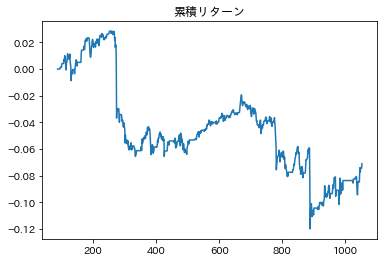

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


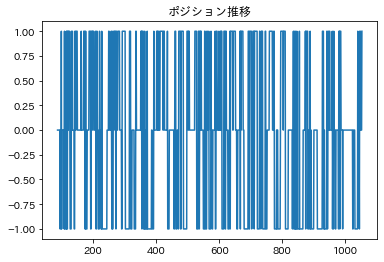

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


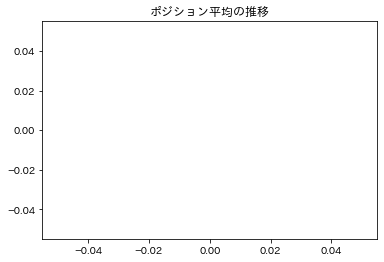

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


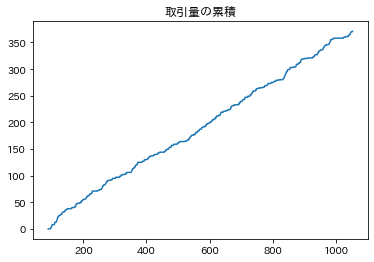

t検定
t値 -0.7363317356782687
p値 0.46170816226680667
p平均法 n = 5
p平均 0.8390389407574362
エラー率 10.828775812508475


In [35]:
@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

df = pd.read_pickle('my_df_fit.pkl')

# バックテストで累積リターンと、ポジションを計算
df['cum_ret'], df['poss'] = backtest(
    cl=df['cl'].values,
    buy_entry=df['y_pred_buy'].values > 0,
    sell_entry=df['y_pred_sell'].values > 0,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
)

df['cum_ret'].plot()
plt.title('累積リターン')
plt.show()

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
df['poss'].plot()
plt.title('ポジション推移')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
df['poss'].rolling(1000).mean().plot()
plt.title('ポジション平均の推移')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
df['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('取引量の累積')
plt.show()

print('t検定')
x = df['cum_ret'].diff(1).dropna()
t, p = ttest_1samp(x, 0)
print('t値 {}'.format(t))
print('p値 {}'.format(p))

# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))


## 良い結果が出たバックテスト例

richmanbtcが実際に使っているボットのバックテスト結果。
青色はハイパーパラメータチューニングや試行錯誤に使った期間。
青色期間とオレンジ色期間をまとめてウォークフォワードでバックテスト。

このように、全期間で右肩上がりになっていると、将来も安定する可能性が高い。
ハイパーパラメータチューニングや試行錯誤に使わないデータ(オレンジ色)を残しておくと、
フィッティングしていないかの最終チェックができるので安心。

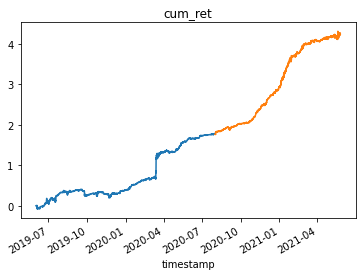


## 実運用

バックテストで良い結果が出たら、実運用をします。
このチュートリアルでは説明しませんが、
機械学習の難易度と比べたら、
かんたんに実装できると思います。
わからない場合は、ネット上にいろいろな人のソースコードが転がっているので、参考にすると良いと思います。

### 注意点

#### どのくらいポジションサイズを増やせるか？

ポジションサイズが増えると、発注サイズが増えます。
発注サイズが増えると、
全量約定しなくなったり、
自分の大きい注文が板に見えることにより、
値動きに影響を与えたりすることがあります。
そのようなことが起きると、
実運用とバックテストが乖離し、
成績が劣化する可能性があります。
それを防ぐために、どのくらいポジションサイズを増やせるか、見積もる必要があります。

GMOコインは約定データが手に入るので、
指値で約定する出来高を調べれば、
どのくらいポジションサイズを増やせるか見積もれます。
例えば、買いの指値であれば、指値より安い価格で約定した注文の出来高を調べれば良いです。

約定データが手に入らない場合は、
全体の売買代金に対する自分のボットの売買代金の割合から見積もる方法もあります。
15分ごとに発注するボットを例として考えます。
1日の売買代金が1000億円だとすると、15分間の売買代金は約10億円と見積もれます。
自分のボットの売買代金を全体の1%とすると、
15分間で発注可能なのは、10億円 * 0.01 = 1000万円です。
ドテンする場合は発注サイズは最大でポジションサイズの2倍になるので、
可能なポジションサイズは500万円以下と見積もれます。
ドテンしない場合は1000万円以下です。

#### 一ヶ月で最大いくら稼げるか？

こうして求められた最大ポジションサイズに月次利益率をかけると、
一ヶ月で稼げる最大額を見積もれます。
例えば、ドテンしない場合で、月次利益率が50%だとすると、500万円です。

見積もった額が自分が必要な額よりも小さい場合、
試行錯誤の結果、もし勝てるようになっても、
必要なリターンを得られないので、
時間の無駄になります。
その場合は、
早々に取引所、取引ペア、時間軸などを変えたほうが、
時間を節約できるかもしれません。


In [36]:
# 最大ポジションサイズと月次利益の見積もり例
amount_per_day_jpy = 1000.0 * 10000 * 10000 # 1日の売買代金 1000億円
order_interval_min = 15.0 # 15分間隔で発注
monthly_return = 0.5 # 月次利益率 50%
my_order_ratio = 0.01 # 自分のボットの売買代金割合 1%

max_position_size = amount_per_day_jpy / (24 * 60) * order_interval_min * my_order_ratio
monthly_profit = max_position_size * monthly_return
print('最大ポジションサイズ {}円'.format(max_position_size))
print('月次利益 {}円'.format(monthly_profit))

最大ポジションサイズ 10416666.666666668円
月次利益 5208333.333333334円


In [56]:
# よみこみ
#df = pd.read_pickle('df_ohlcv_with_fee.pkl')
df = pd.read_csv('binance_btc_usdt_15m.csv')

# use binance data
df.columns = ['datetime', 'op', 'hi', 'lo', 'cl', 'volume']


df['fee'] = 0
# インデックスを日付型に変換
#df.index = pd.to_datetime(df.index)
#df.set_index('datetime', inplace=True)


# DateTime列を日付型に変換
df['datetime'] = pd.to_datetime(df['datetime'])

# 2024年のデータだけをフィルタリング
df = df[(df['datetime'].dt.year == 2024) & (df['datetime'].dt.month == 2) & (df['datetime'].dt.day == 2)]



df = df.dropna()
df = calc_features(df)
display(df)

,datetime,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,...,ATR,NATR,HT_DCPERIOD,HT_DCPHASE,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG_ANGLE
399894,2024-02-02 00:00:00,42651.10,42800.00,42580.00,42787.24,1134.11568,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
399895,2024-02-02 00:15:00,42787.24,42933.00,42687.73,42905.24,611.51697,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
399896,2024-02-02 00:30:00,42905.25,42946.60,42677.61,42707.87,600.40612,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
399897,2024-02-02 00:45:00,42707.88,42731.10,42516.11,42516.12,534.99163,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
399898,2024-02-02 01:00:00,42516.12,42622.26,42428.10,42622.25,671.36291,0,0.010556,0.004283,-0.001990,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399985,2024-02-02 22:45:00,42846.00,42864.00,42546.79,42694.01,1235.30922,0,0.013937,0.006084,-0.001770,...,110.856804,0.259654,19.613027,214.935707,-0.572657,-0.984612,0,0.729062,0.888125,-86.979257
399986,2024-02-02 23:00:00,42694.01,42788.00,42610.00,42760.31,527.00667,0,0.011962,0.004491,-0.002980,...,115.652747,0.270468,19.493815,241.606032,-0.879699,-0.958292,0,0.708016,0.918203,-87.973780
399987,2024-02-02 23:15:00,42760.30,42771.10,42653.32,42710.42,352.41813,0,0.009225,0.002508,-0.004208,...,115.804694,0.271139,19.455264,262.998437,-0.992543,-0.788028,0,0.860047,0.929998,-88.412930
399988,2024-02-02 23:30:00,42710.42,42806.84,42710.42,42779.87,399.72987,0,0.002513,-0.000012,-0.002537,...,114.420073,0.267462,19.725909,279.853806,-0.985248,-0.575665,0,0.960575,0.934940,-88.622082


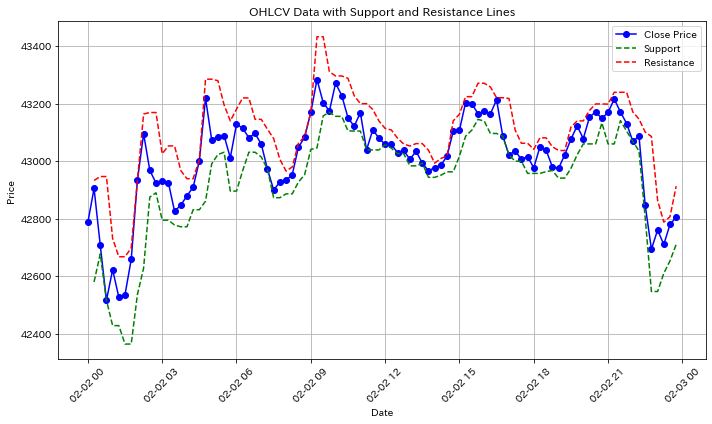

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# サンプルデータの生成
# data = {
#     'Date': pd.date_range(start='2023-01-01', periods=5, freq='D'),
#     'Open': [100, 102, 101, 103, 102],
#     'High': [105, 108, 106, 110, 109],
#     'Low': [95, 97, 96, 99, 98],
#     'Close': [102, 105, 104, 108, 107],
# }
#df = pd.DataFrame(data)

# サポートとレジスタンスの計算（簡易版）
df['Support'] = df['lo'].rolling(window=2).min()
df['Resistance'] = df['hi'].rolling(window=2).max()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['cl'], label='Close Price', color='blue', marker='o')
#plt.plot(df['datetime'], df['hi'], label='High Price', color='purple', marker='o')

plt.plot(df['datetime'], df['Support'], label='Support', color='green', linestyle='--')
plt.plot(df['datetime'], df['Resistance'], label='Resistance', color='red', linestyle='--')

plt.title('OHLCV Data with Support and Resistance Lines')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [84]:
import pandas as pd
import numpy as np

# サンプルデータの生成
np.random.seed(0)
dates = pd.date_range(start='2023-01-01', periods=100, freq='D')
data = np.random.rand(100, 5) * 100
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df = pd.DataFrame(data, index=dates, columns=columns)

# 最近100日間の最高値と最低値を基にフィボナッチリトレースメントレベルを計算
high = df['High'].max()
low = df['Low'].min()
diff = high - low

# フィボナッチリトレースメントレベルを基にbuy_priceとsell_priceを計算
fib_levels = [0.236, 0.382, 0.5, 0.618, 0.786]
fib_prices = {level: high - (diff * level) for level in fib_levels}

# 例として、38.2%のリトレースメントレベルをbuy_priceとして、61.8%のリトレースメントレベルをsell_priceとする
buy_price = fib_prices[0.382]
sell_price = fib_prices[0.618]

print(f"Buy Price: {buy_price:.2f}")
print(f"Sell Price: {sell_price:.2f}")


Buy Price: 61.77
Sell Price: 38.64
